<a href="https://colab.research.google.com/github/diegopaez03/WBC-Classifier/blob/main/dev/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador de glóbulos blancos en Frotis Sanguíneo

Para este proyecto usaremos el dataset RV-PBS de Jimut13, su repositorio esta en:
https://github.com/Jimut123/RV-PBS.git

Este proyecto propone el desarrollo de una red neuronal profunda que permita detectar,
contar y clasificar glóbulos blancos en imágenes microscópicas de frotis
sanguíneo. En América Latina, esta tarea suele hacerse manualmente por personal técnico en
laboratorios, lo cual puede ser propenso a errores y es sumamente tedioso. Este sistema
automatizado tiene como fin agilizar el proceso, reducir errores y servir como herramienta de
apoyo al diagnóstico hematológico.

### Dataset
- Imagenes de 4032x3024 px de resolución
- Etiquetas en xml
- Clases (10)
  - Band Cell
  - Basophil
  - Blast Cell
  - Eosinophils
  - Lymphocytes
  - Myelocytes
  - Metamyelocytes
  - Monocytes
  - Neutrhophil
  - Promtelocytes

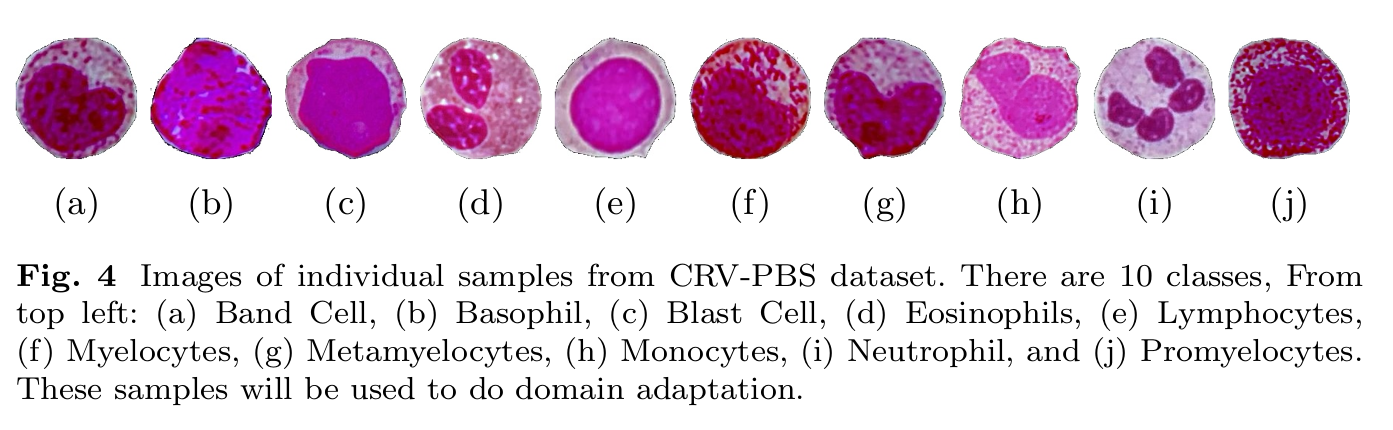

### Script para organizar el dataset para YOLO

In [1]:
!git clone https://github.com/Jimut123/RV-PBS.git

Cloning into 'RV-PBS'...
remote: Enumerating objects: 1356, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1356 (delta 31), reused 23 (delta 3), pack-reused 1289 (from 1)
Receiving objects: 100% (1356/1356), 732.17 MiB | 17.97 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Updating files: 100% (760/760), done.


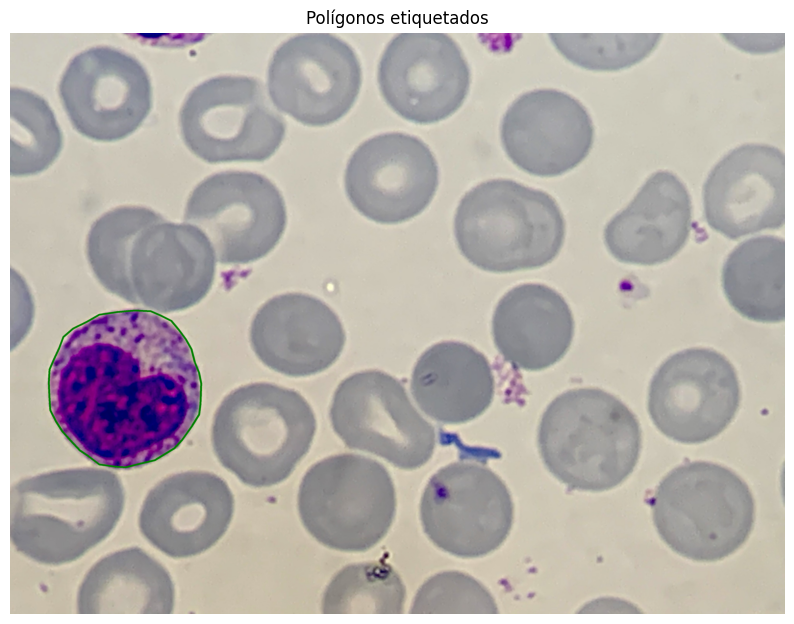

In [2]:
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Rutas a los archivos
image_path = "RV-PBS/BAND CELLS/IMG_2919.jpg"
xml_path = "RV-PBS/BAND CELLS/annotations.xml"

# Cargar imagen
image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)

# Parsear XML
tree = ET.parse(xml_path)
root = tree.getroot()

# Buscar las etiquetas con su polígono para esta imagen
for image_tag in root.findall("image"):
    if image_tag.get("name") == "IMG_2919.jpg":
        for polygon in image_tag.findall("polygon"):
            points_str = polygon.get("points")  # "x1,y1;x2,y2;..."
            points = [(float(x), float(y)) for x, y in (p.split(",") for p in points_str.split(";"))]
            draw.polygon(points, outline="green", width=10)

# Mostrar la imagen con matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.title("Polígonos etiquetados")
plt.show()


Como podemos observar, el etiquetado ha sido realizado con polígonos, lo cual no nos sirve, ya que nosotros necesitamos una bounding box.
Por lo cual necesitaremos convertir estos polígonos a un recuadro rectangular

In [5]:
def get_bounding_box(points):
    """
    Calcula la bounding box mínima que encierra un polígono.

    Parámetros:
    - points: lista de tuplas (x, y) con las coordenadas del polígono.

    Retorna:
    - (xmin, ymin, xmax, ymax)
    """
    xs = [x for x, y in points]
    ys = [y for x, y in points]
    xmin = min(xs)
    xmax = max(xs)
    ymin = min(ys)
    ymax = max(ys)
    return xmin, ymin, xmax, ymax


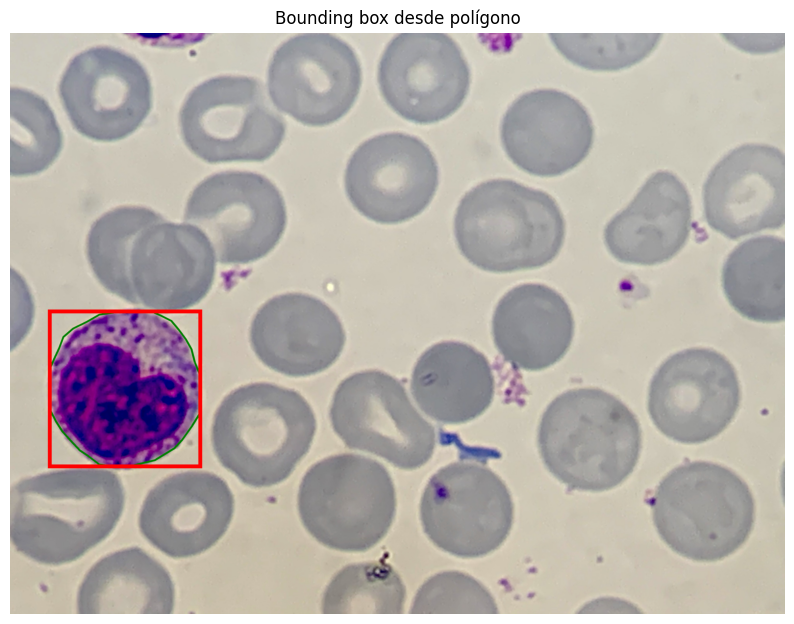

In [4]:
# Buscar las etiquetas con bounding box para esta imagen
for image_tag in root.findall("image"):
    if image_tag.get("name") == "IMG_2919.jpg":
        for polygon in image_tag.findall("polygon"):
            points_str = polygon.get("points")  # "x1,y1;x2,y2;..."
            points = [(float(x), float(y)) for x, y in (p.split(",") for p in points_str.split(";"))]
            draw.polygon(points, outline="green", width=10)

            # Dibujar bounding box
            xmin, ymin, xmax, ymax = get_bounding_box(points)
            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="red", width=20)

# Mostrar la imagen con matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.title("Bounding box desde polígono")
plt.show()

In [3]:
# Clases
class_names = [
    "band cell", "basophil", "blast cell", "eosinophil",
    "lymphocyte", "monocyte", "neutrophil", "promyelocyte",
    "myelocyte", "metamyelocyte"
]

In [6]:
import os
import xml.etree.ElementTree as ET
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# --- Configuración ---
dataset_root = "RV-PBS"  # Ruta del dataset original
output_path = "RV-PBS_YOLO"  # Ruta de salida para YOLOv8
test_size = 0.2  # 20% para validación

# --- Funciones ---
def xml_to_yolo(xml_file, image_name, output_labels_dir):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_elem = root.find(f"image[@name='{image_name}']")
    if image_elem is None:
        return  # No anotaciones para esta imagen

    img_width = int(image_elem.get("width"))
    img_height = int(image_elem.get("height"))

    txt_filename = os.path.splitext(image_name)[0] + ".txt"
    txt_path = os.path.join(output_labels_dir, txt_filename)

    with open(txt_path, "w") as f:
        for polygon in image_elem.findall("polygon"):
            label = polygon.get("label")
            if label not in class_names:
                continue
            class_id = class_names.index(label)

            point_list = [(float(x), float(y)) for x, y in
                          (p.split(",") for p in polygon.get("points").split(";"))]
            x_min, y_min, x_max, y_max = get_bounding_box(point_list)

            x_center = (x_min + x_max) / 2 / img_width
            y_center = (y_min + y_max) / 2 / img_height
            width = (x_max - x_min) / img_width
            height = (y_max - y_min) / img_height

            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

def organize_dataset():
    os.makedirs(f"{output_path}/images/train", exist_ok=True)
    os.makedirs(f"{output_path}/images/val", exist_ok=True)
    os.makedirs(f"{output_path}/labels/train", exist_ok=True)
    os.makedirs(f"{output_path}/labels/val", exist_ok=True)

    image_paths = []
    image_xml_map = {}

    for class_dir in glob(f"{dataset_root}/*"):
        if not os.path.isdir(class_dir):
            continue

        class_xml = os.path.join(class_dir, "annotations.xml")
        if not os.path.exists(class_xml):
            continue

        tree = ET.parse(class_xml)
        root = tree.getroot()

        for image_elem in root.findall("image"):
            image_name = image_elem.get("name")
            image_path = os.path.join(class_dir, image_name)
            if os.path.exists(image_path):
                image_paths.append(image_path)
                image_xml_map[image_path] = class_xml

    # Dividir en train/val
    train_images, val_images = train_test_split(image_paths, test_size=test_size, random_state=42)

    # Procesar entrenamiento
    for img_path in tqdm(train_images, desc="Procesando Train"):
        img_name = os.path.basename(img_path)
        shutil.copy(img_path, f"{output_path}/images/train/{img_name}")
        xml_to_yolo(image_xml_map[img_path], img_name, f"{output_path}/labels/train")

    # Procesar validación
    for img_path in tqdm(val_images, desc="Procesando Val"):
        img_name = os.path.basename(img_path)
        shutil.copy(img_path, f"{output_path}/images/val/{img_name}")
        xml_to_yolo(image_xml_map[img_path], img_name, f"{output_path}/labels/val")

    print(f"\n¡Dataset organizado!")
    print(f"Imágenes de entrenamiento: {len(train_images)}")
    print(f"Imágenes de validación: {len(val_images)}")

# Ejecutar
organize_dataset()

Procesando Val: 100%|██████████| 117/117 [00:01<00:00, 108.70it/s]


¡Dataset organizado!
Imágenes de entrenamiento: 466
Imágenes de validación: 117


In [7]:
import cv2
import random
import matplotlib.pyplot as plt

# Configuración
dataset_path = "RV-PBS_YOLO"  # Ruta del dataset organizado

# Colores aleatorios para cada clase
colors = {
    i: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    for i in range(len(class_names))
}

In [8]:
def plot_bboxes(img_path, label_path):
    """Dibuja bounding boxes en una imagen y la muestra"""
    # Leer imagen
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Leer anotaciones YOLO
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Dibujar cada bbox
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.split())
        class_id = int(class_id)

        # Convertir coordenadas YOLO a píxeles
        x1 = int((x_center - width/2) * w)
        y1 = int((y_center - height/2) * h)
        x2 = int((x_center + width/2) * w)
        y2 = int((y_center + height/2) * h)

        # Dibujar bbox y etiqueta
        cv2.rectangle(img, (x1, y1), (x2, y2), colors[class_id], 20)
        cv2.putText(
            img,
            class_names[class_id],
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            colors[class_id],
            1
        )

    # Mostrar imagen
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Bounding Boxes - {os.path.basename(img_path)}")
    plt.show()

In [7]:
# --- Seleccionar imágenes aleatorias para visualizar ---
def visualize_random_samples(num_samples=3, split='train'):
    """Visualiza muestras aleatorias del dataset"""
    images_dir = f"{dataset_path}/images/{split}"
    labels_dir = f"{dataset_path}/labels/{split}"

    # Obtener lista de imágenes
    img_files = glob(f"{images_dir}/*.jpg") + glob(f"{images_dir}/*.png")
    selected_imgs = random.sample(img_files, min(num_samples, len(img_files)))

    for img_path in selected_imgs:
        label_path = f"{labels_dir}/{os.path.splitext(os.path.basename(img_path))[0]}.txt"
        if os.path.exists(label_path):
            plot_bboxes(img_path, label_path)
        else:
            print(f"⚠️ No se encontró etiqueta para: {img_path}")


=== Muestras de Entrenamiento ===


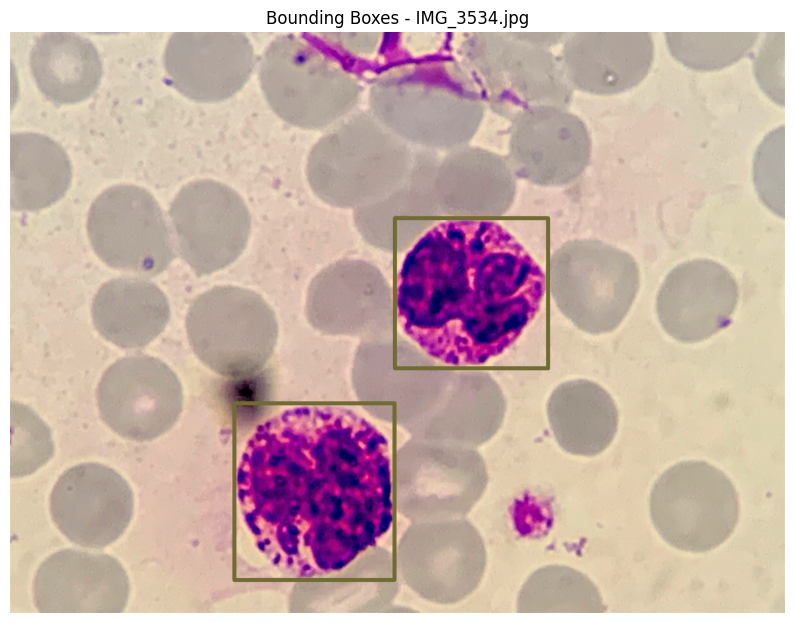


=== Muestras de Validación ===


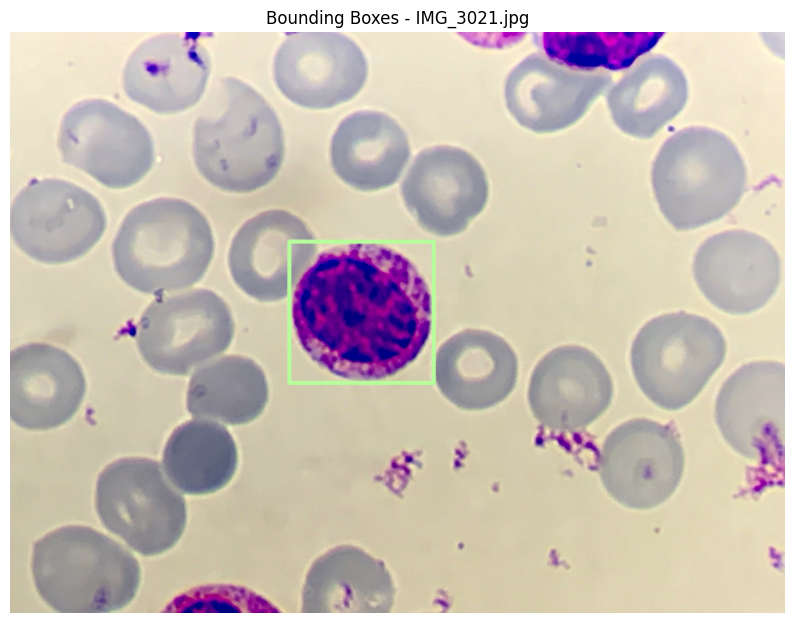

In [ ]:
# Visualizar 3 muestras de entrenamiento y 1 de validación
print("=== Muestras de Entrenamiento ===")
visualize_random_samples(num_samples=1, split='train')

print("\n=== Muestras de Validación ===")
visualize_random_samples(num_samples=1, split='val')

Crearemos nuestro archivo data.yaml

In [9]:
with open("data.yaml", "w") as f:
    f.write("""\
path: RV-PBS_YOLO
train: images/train
val: images/val
nc: 10
names: [
    "band cell", "basophil", "blast cell", "eosinophil",
    "lymphocyte", "monocyte", "neutrophil", "promyelocyte",
    "myelocyte", "metamyelocyte"
]
""")

Trabajaremos con Ultralytics para realizar el fine-tuning

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

## Entrenamiento del modelo

### Entrenar modelo desde YOLO

In [32]:
from ultralytics import YOLO

# Cargar el modelo preentrenado
model = YOLO("yolov8n.pt")  # o yolov8m.pt, yolov8s.pt, etc.

# Entrenar con tu dataset
model.train(
    data="data.yaml",
    epochs=60,
    imgsz=640,
    batch=16,
    workers=2,
    name="wbc_yolo",
)


100%|██████████| 6.25M/6.25M [00:00<00:00, 86.0MB/s]

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=wbc_yolo14, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile

  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384,

UnpicklingError: invalid load key, '<'.

Evaluar el modelo

In [12]:
metrics = model.val()

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 27.6MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 114.9±26.6 MB/s, size: 972.6 KB)



val: Scanning /content/RV-PBS_YOLO/labels/val... 117 images, 0 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<00:00, 257.11it/s]

val: New cache created: /content/RV-PBS_YOLO/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


                   all        117        141      0.836      0.909      0.921        0.9
             band cell         16         16      0.563          1      0.982      0.971
            blast cell         13         25      0.925      0.989      0.989      0.973
            eosinophil         18         25          1      0.964      0.995      0.979
            lymphocyte         13         14      0.847          1      0.995      0.935
              monocyte         14         14      0.912          1       0.99       0.99
            neutrophil         19         21       0.95      0.899      0.983      0.949
          promyelocyte          5          7       0.66      0.857      0.741      0.741
             myelocyte         12         12      0.664      0.917      0.881      0.854
         metamyelocyte          7          7          1      0.552      0.736      0.708
Speed: 2.6ms preprocess, 4.8ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to runs/detect

Guardamos el modelo y los resultados en google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import os

# Ruta base (ajústala si tu notebook está en una subcarpeta)
base_path = "/content/drive/MyDrive/FrotisSanguineoNet"

# Carpetas a crear
model_dir = os.path.join(base_path, "wbc_model_output")
others_dir = os.path.join(base_path, "wbc_otros_archivos")
yolo_dir = os.path.join(base_path, "wbc_yolo_model")


results_train_dir = os.path.join(base_path, "wbc_otros_archivos/train")
results_val_dir = os.path.join(base_path, "wbc_otros_archivos/val")

# Crear si no existen
os.makedirs(model_dir, exist_ok=True)
os.makedirs(others_dir, exist_ok=True)
os.makedirs(yolo_dir, exist_ok=True)

os.makedirs(results_train_dir, exist_ok=True)
os.makedirs(results_val_dir, exist_ok=True)

In [20]:
# Copiar modelo y gráficos al folder del modelo
!cp runs/detect/wbc_yolo/weights/best.pt /content/drive/MyDrive/FrotisSanguineoNet/wbc_model_output/
!cp runs/detect/wbc_yolo/results.png /content/drive/MyDrive/FrotisSanguineoNet/wbc_model_output/
!cp yolov8n.pt /content/drive/MyDrive/FrotisSanguineoNet/wbc_yolo_model/

# Copiar todos los resultados
!cp -r runs/detect/wbc_yolo /content/drive/MyDrive/FrotisSanguineoNet/wbc_otros_archivos/train
!cp -r runs/detect/wbc_yolo2 /content/drive/MyDrive/FrotisSanguineoNet/wbc_otros_archivos/val


cp: cannot stat 'yolov8n.pt': No such file or directory


In [14]:

!cp -r runs/detect/val /content/drive/MyDrive/FrotisSanguineoNet/wbc_otros_archivos/val

### Cargar modelo ya entrenado

In [10]:
from ultralytics import YOLO

model = YOLO("/content/drive/MyDrive/FrotisSanguineoNet/wbc_model_output/best.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### Ver métricas

Calcular MAE y accuracy

In [11]:
from torchvision.ops import box_iou
import torch
from collections import defaultdict

# Accuracy por detección
def detection_accuracy(pred_boxes, gt_boxes, iou_threshold=0.5):
    if len(pred_boxes) == 0 or len(gt_boxes) == 0:
        return 0.0

    pred_coords = torch.tensor([b[:4] for b in pred_boxes])
    pred_classes = [int(b[5]) for b in pred_boxes]
    gt_coords = torch.tensor([b[:4] for b in gt_boxes])
    gt_classes = [int(b[4]) for b in gt_boxes]

    ious = box_iou(pred_coords, gt_coords)
    matches = 0

    for i, pred_class in enumerate(pred_classes):
        best_iou, gt_idx = torch.max(ious[i], dim=0)
        if best_iou > iou_threshold and pred_class == gt_classes[gt_idx]:
            matches += 1

    return matches / len(pred_boxes)

# MAE de conteo por clase
def count_mae(pred_counts: dict, gt_counts: dict):
    total_error = 0
    total_classes = 0
    for cls in gt_counts:
        pred = pred_counts.get(cls, 0)
        true = gt_counts[cls]
        total_error += abs(pred - true)
        total_classes += 1
    return total_error / total_classes if total_classes else 0.0


In [12]:
metrics = model.val(data="data.yaml", imgsz=640, split="val")

Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 141MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3066.9±1589.0 MB/s, size: 922.1 KB)



val: Scanning /content/RV-PBS_YOLO/labels/val... 117 images, 0 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<00:00, 651.52it/s]


val: New cache created: /content/RV-PBS_YOLO/labels/val.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.53s/it]


                   all        117        150      0.938      0.928      0.981      0.962
             band cell          9          9      0.648          1      0.975      0.975
              basophil          5          5      0.942          1      0.995      0.995
            blast cell         14         31      0.999          1      0.995      0.984
            eosinophil         18         23          1      0.952      0.995      0.995
            lymphocyte          7          7       0.87          1      0.995      0.975
              monocyte         12         12      0.994      0.917      0.984      0.972
            neutrophil         24         27          1      0.929      0.995      0.963
          promyelocyte          6         13          1      0.953      0.995      0.946
             myelocyte         14         15       0.93          1      0.982      0.941
         metamyelocyte          8          8          1      0.525      0.899      0.876
Speed: 3.2ms preproce

In [15]:
# Obtener métricas por clase
precisiones = metrics.box.p       # Lista de precisión por clase
recalls = metrics.box.r           # Lista de recall por clase
map50s = metrics.box.ap50         # Lista de mAP@0.5 por clase
maps = metrics.box.ap             # Lista de mAP@0.5:0.95 por clase

In [16]:
for i, name in enumerate(class_names):
    print(f"{name}: Precisión={precisiones[i]:.2f}, Recall={recalls[i]:.2f}, mAP@0.5={map50s[i]:.2f}, mAP@0.5:0.95={maps[i]:.2f}")

band cell: Precisión=0.65, Recall=1.00, mAP@0.5=0.98, mAP@0.5:0.95=0.97
basophil: Precisión=0.94, Recall=1.00, mAP@0.5=0.99, mAP@0.5:0.95=0.99
blast cell: Precisión=1.00, Recall=1.00, mAP@0.5=0.99, mAP@0.5:0.95=0.98
eosinophil: Precisión=1.00, Recall=0.95, mAP@0.5=0.99, mAP@0.5:0.95=0.99
lymphocyte: Precisión=0.87, Recall=1.00, mAP@0.5=0.99, mAP@0.5:0.95=0.98
monocyte: Precisión=0.99, Recall=0.92, mAP@0.5=0.98, mAP@0.5:0.95=0.97
neutrophil: Precisión=1.00, Recall=0.93, mAP@0.5=0.99, mAP@0.5:0.95=0.96
promyelocyte: Precisión=1.00, Recall=0.95, mAP@0.5=0.99, mAP@0.5:0.95=0.95
myelocyte: Precisión=0.93, Recall=1.00, mAP@0.5=0.98, mAP@0.5:0.95=0.94
metamyelocyte: Precisión=1.00, Recall=0.52, mAP@0.5=0.90, mAP@0.5:0.95=0.88


In [19]:
from ultralytics.utils.plotting import Annotator
import os
import cv2

# Cargar una imagen del val set
img_path = "/content/RV-PBS_YOLO/images/val/IMG_4176.jpg"
label_path = img_path.replace("/images/", "/labels/").replace(".jpg", ".txt")

# Realizar la predicción
results = model(img_path)[0]

# Obtener pred_boxes: [x1, y1, x2, y2, conf, class_id]
pred_boxes = results.boxes.data.cpu().numpy().tolist()

# Obtener gt_boxes: [x1, y1, x2, y2, class_id]
h, w = cv2.imread(img_path).shape[:2]
gt_boxes = []
with open(label_path, "r") as f:
    for line in f:
        cls, x, y, bw, bh = map(float, line.strip().split())
        x1 = (x - bw / 2) * w
        y1 = (y - bh / 2) * h
        x2 = (x + bw / 2) * w
        y2 = (y + bh / 2) * h
        gt_boxes.append([x1, y1, x2, y2, int(cls)])

# Métricas personalizadas
acc = detection_accuracy(pred_boxes, gt_boxes)
print(f"Detection Accuracy: {acc:.2f}")

# Conteos
def count_by_class(boxes, idx_cls=5):  # idx_cls=5 para pred, 4 para gt
    counts = defaultdict(int)
    for box in boxes:
        cls = int(box[idx_cls])
        counts[cls] += 1
    return counts

pred_counts = count_by_class(pred_boxes, idx_cls=5)
gt_counts = count_by_class(gt_boxes, idx_cls=4)
mae = count_mae(pred_counts, gt_counts)
print(f"Conteo MAE: {mae:.2f}")



image 1/1 /content/RV-PBS_YOLO/images/val/IMG_4176.jpg: 480x640 4 blast cells, 7.6ms
Speed: 4.1ms preprocess, 7.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)
Detection Accuracy: 1.00
Conteo MAE: 0.00


In [20]:
from tabulate import tabulate

# Mostrar conteo total
print(f"\n▶ Total de objetos detectados: {len(pred_boxes)}")
print(f"▶ Total de objetos reales: {len(gt_boxes)}")

# Contar por clase
pred_counts = count_by_class(pred_boxes, idx_cls=5)
gt_counts = count_by_class(gt_boxes, idx_cls=4)

print("\n▶ Conteo por clase:")
print("{:<15}{:<10}{:<10}".format("Clase", "Predicho", "Real"))
for cls_id in sorted(set(list(pred_counts.keys()) + list(gt_counts.keys()))):
    pred_c = pred_counts.get(cls_id, 0)
    real_c = gt_counts.get(cls_id, 0)
    print(f"{class_names[cls_id]:<15}{pred_c:<10}{real_c:<10}")



▶ Total de objetos detectados: 4
▶ Total de objetos reales: 4

▶ Conteo por clase:
Clase          Predicho  Real      
blast cell     4         4         


In [21]:
# Comparar cada predicción con el ground truth
ious = box_iou(torch.tensor([b[:4] for b in pred_boxes]),
               torch.tensor([b[:4] for b in gt_boxes]))

results_table = []

for i, pred in enumerate(pred_boxes):
    pred_class = int(pred[5])
    pred_conf = pred[4]

    iou_vals = ious[i]
    best_iou, gt_idx = torch.max(iou_vals, dim=0)

    if best_iou > 0.5:
        gt_class = int(gt_boxes[gt_idx][4])
        match = pred_class == gt_class
    else:
        gt_class = None
        match = False

    results_table.append([
        i+1,
        class_names[pred_class],
        f"{pred_conf:.2f}",
        f"{best_iou:.2f}" if gt_class is not None else "-",
        class_names[gt_class] if gt_class is not None else "Ninguno",
        "✅" if match else "❌"
    ])

print("\n▶ Resultados de predicciones:")
print(tabulate(results_table, headers=["#", "Predicho", "Confianza", "IoU", "Real", "Coincide"]))



▶ Resultados de predicciones:
  #  Predicho      Confianza    IoU  Real        Coincide
---  ----------  -----------  -----  ----------  ----------
  1  blast cell         1      0.97  blast cell  ✅
  2  blast cell         0.98   0.97  blast cell  ✅
  3  blast cell         0.97   0.96  blast cell  ✅
  4  blast cell         0.94   0.95  blast cell  ✅


Guardar metricas en csv

In [17]:
import pandas as pd

# Construir DataFrame
data = {
    "Clase": class_names,
    "Precisión": [f"{p:.2f}" for p in precisiones],
    "Recall": [f"{r:.2f}" for r in recalls],
    "mAP@0.5": [f"{m:.2f}" for m in map50s],
    "mAP@0.5:0.95": [f"{m:.2f}" for m in maps],
}

df = pd.DataFrame(data)
df.to_csv("metrics_por_clase.csv", index=False)

### Seguir entrenando modelo

In [12]:
model.train(data="data.yaml", epochs=5)

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/FrotisSanguineoNet/wbc_model_output/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0

train: Scanning /content/RV-PBS_YOLO/labels/train.cache... 464 images, 0 backgrounds, 0 corrupt: 100%|██████████| 464/464 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1669.2±1646.4 MB/s, size: 965.6 KB)


val: Scanning /content/RV-PBS_YOLO/labels/val.cache... 117 images, 0 backgrounds, 0 corrupt: 100%|██████████| 117/117 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.11G     0.3561     0.7948     0.8646         39        640: 100%|██████████| 29/29 [00:40<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        117        141      0.721      0.875      0.863      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.32G     0.3566     0.6822     0.8524         54        640: 100%|██████████| 29/29 [00:47<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]

                   all        117        141      0.725      0.849      0.818      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.32G     0.3542     0.6248     0.8592         38        640: 100%|██████████| 29/29 [00:57<00:00,  2.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]

                   all        117        141      0.831      0.866      0.903      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.32G     0.3488     0.6266     0.8665         33        640: 100%|██████████| 29/29 [00:47<00:00,  1.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.34it/s]

                   all        117        141      0.822      0.808      0.871      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.32G     0.3309     0.5731     0.8507         37        640: 100%|██████████| 29/29 [00:36<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all        117        141      0.739      0.885      0.877       0.86



5 epochs completed in 0.068 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:29<00:00,  7.46s/it]


                   all        117        141      0.831      0.866      0.903      0.874
             band cell         16         16      0.929      0.819      0.936       0.92
            blast cell         13         25      0.894          1      0.995      0.968
            eosinophil         18         25      0.935          1       0.99      0.974
            lymphocyte         13         14       0.93       0.95      0.981      0.932
              monocyte         14         14      0.925      0.887      0.981      0.965
            neutrophil         19         21      0.902          1      0.991      0.938
          promyelocyte          5          7      0.713      0.429      0.677      0.677
             myelocyte         12         12      0.511          1      0.841      0.797
         metamyelocyte          7          7      0.735      0.714      0.736      0.697
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs/detect

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b5502837610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0470

## Probar la red

In [13]:
def mostrar_predicciones_yolo(model, img_path, conf=0.25):
    """
    Muestra una imagen con las predicciones del modelo YOLOv8.

    Parámetros:
    - model: modelo YOLO cargado
    - img_path: ruta a la imagen
    - conf: umbral de confianza (por defecto: 0.25)
    """
    # Leer imagen
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Realizar predicción
    results = model.predict(img_path, conf=conf, save=False)

    for r in results:
        for box in r.boxes:
            class_id = int(box.cls.item())
            confidence = box.conf.item()
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Dibujar bbox
            cv2.rectangle(img, (x1, y1), (x2, y2), colors[class_id], 6)

            # Etiqueta con clase y confianza
            label = f"{class_names[class_id]} {confidence:.2f}"
            cv2.putText(img, label, (x1, y1 - 8), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 2)

    # Mostrar imagen
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicción YOLOv8 - {os.path.basename(img_path)}")
    plt.show()



image 1/1 /content/RV-PBS/TEST_MIXED/IMG_4279.jpg: 480x640 2 blast cells, 4 promyelocytes, 6 myelocytes, 37.8ms
Speed: 4.1ms preprocess, 37.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


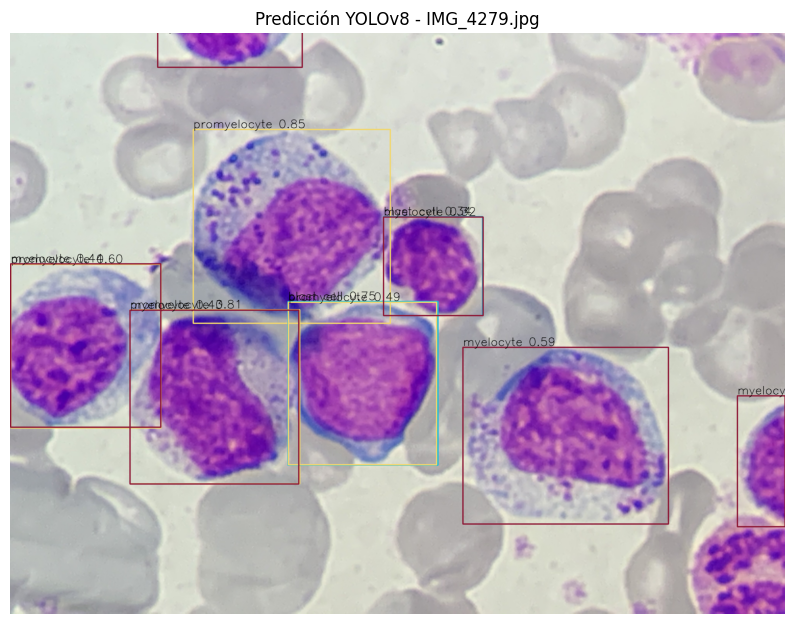

In [14]:
mostrar_predicciones_yolo(model, "/content/RV-PBS/TEST_MIXED/IMG_4279.jpg", conf=0.3)


image 1/1 /content/RV-PBS/TEST_MIXED/IMG_4305.jpg: 480x640 1 blast cell, 2 promyelocytes, 3 myelocytes, 7.3ms
Speed: 3.5ms preprocess, 7.3ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


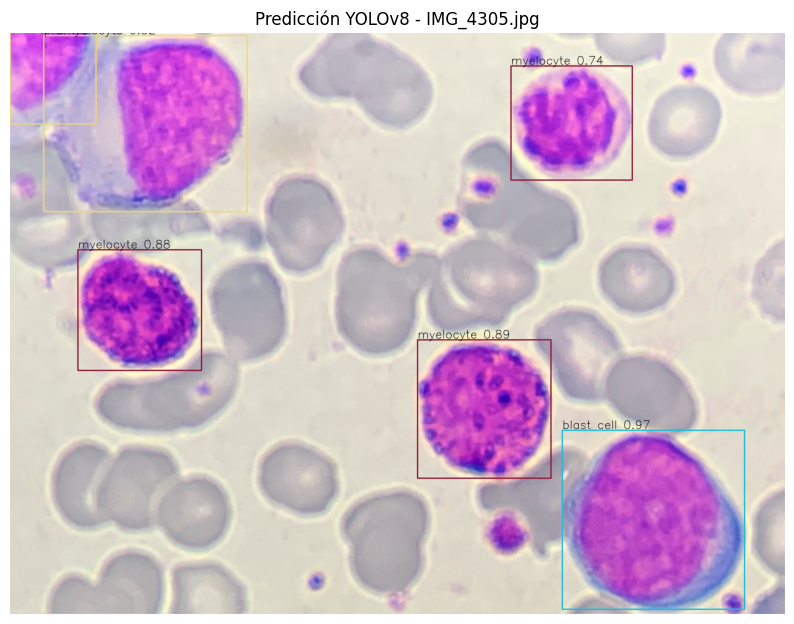

In [15]:
mostrar_predicciones_yolo(model, "/content/RV-PBS/TEST_MIXED/IMG_4305.jpg", conf=0.3)


image 1/1 /content/RV-PBS/TEST_MIXED/IMG_4293.jpg: 480x640 3 band cells, 1 basophil, 1 neutrophil, 4 myelocytes, 7.1ms
Speed: 3.5ms preprocess, 7.1ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 640)


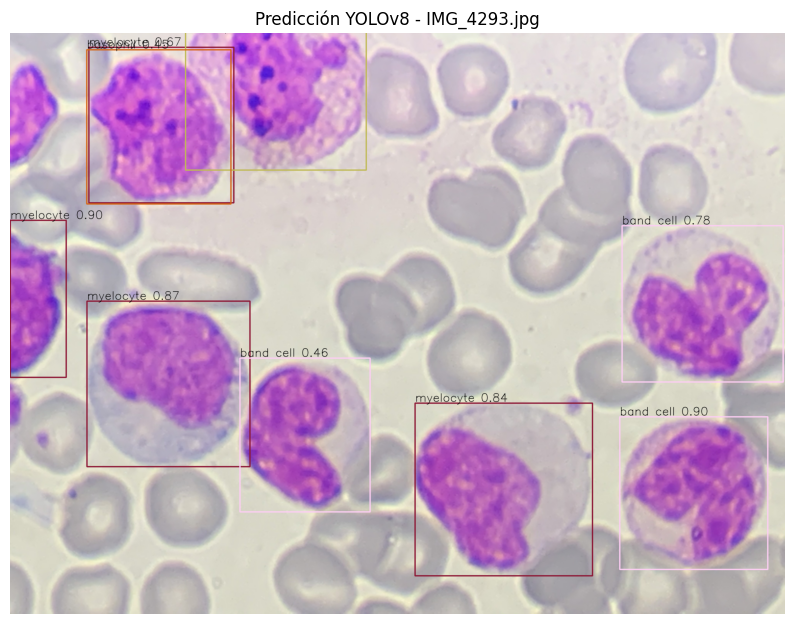

In [16]:
mostrar_predicciones_yolo(model, "/content/RV-PBS/TEST_MIXED/IMG_4293.jpg", conf=0.3)

In [ ]:
mostrar_predicciones_yolo(model, "/content/RV-PBS/TEST_MIXED/IMG_4296.jpg", conf=0.3)

In [15]:
mostrar_predicciones_yolo(model, "/content/RV-PBS/TEST_MIXED/IMG_4300.jpg", conf=0.3)

NameError: name 'mostrar_predicciones_yolo' is not defined

In [17]:
import csv

# Rutas
labels_dir = "/content/RV-PBS_YOLO/labels/train"
images_dir = "/content/RV-PBS_YOLO/images/train"
output_csv = "training_data.csv"

# Cabecera del CSV
header = ["image_path", "width", "height", "class_id", "x_center_norm", "y_center_norm", "width_norm", "height_norm"]

# Crear CSV
with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)

    for label_path in glob(os.path.join(labels_dir, "*.txt")):
        base_name = os.path.splitext(os.path.basename(label_path))[0]
        image_path_jpg = os.path.join(images_dir, base_name + ".jpg")
        image_path_png = os.path.join(images_dir, base_name + ".png")

        # Buscar si existe .jpg o .png
        if os.path.exists(image_path_jpg):
            image_path = image_path_jpg
        elif os.path.exists(image_path_png):
            image_path = image_path_png
        else:
            print(f"No se encontró imagen para {label_path}, se omite.")
            continue

        # Leer dimensiones de la imagen
        img = cv2.imread(image_path)
        if img is None:
            print(f"No se pudo leer la imagen: {image_path}")
            continue
        h, w = img.shape[:2]

        # Leer etiquetas
        with open(label_path, "r") as f:
            for line in f:
                class_id, x_c, y_c, width, height = map(float, line.strip().split())
                writer.writerow([image_path, w, h, int(class_id), x_c, y_c, width, height])

print(f"CSV generado correctamente: {output_csv}")


CSV generado correctamente: training_data.csv


In [18]:
import csv

# Rutas
labels_dir = "/content/RV-PBS_YOLO/labels/val"
images_dir = "/content/RV-PBS_YOLO/images/val"
output_csv = "test_data.csv"

# Cabecera del CSV
header = ["image_path", "width", "height", "class_id", "x_center_norm", "y_center_norm", "width_norm", "height_norm"]

# Crear CSV
with open(output_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)

    for label_path in glob(os.path.join(labels_dir, "*.txt")):
        base_name = os.path.splitext(os.path.basename(label_path))[0]
        image_path_jpg = os.path.join(images_dir, base_name + ".jpg")
        image_path_png = os.path.join(images_dir, base_name + ".png")

        # Buscar si existe .jpg o .png
        if os.path.exists(image_path_jpg):
            image_path = image_path_jpg
        elif os.path.exists(image_path_png):
            image_path = image_path_png
        else:
            print(f"No se encontró imagen para {label_path}, se omite.")
            continue

        # Leer dimensiones de la imagen
        img = cv2.imread(image_path)
        if img is None:
            print(f"No se pudo leer la imagen: {image_path}")
            continue
        h, w = img.shape[:2]

        # Leer etiquetas
        with open(label_path, "r") as f:
            for line in f:
                class_id, x_c, y_c, width, height = map(float, line.strip().split())
                writer.writerow([image_path, w, h, int(class_id), x_c, y_c, width, height])

print(f"CSV generado correctamente: {output_csv}")


CSV generado correctamente: test_data.csv
